In [13]:
"""
The MIT License (MIT)
Copyright (c) 2021 NVIDIA
Permission is hereby granted, free of charge, to any person obtaining a copy of
this software and associated documentation files (the "Software"), to deal in
the Software without restriction, including without limitation the rights to
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
the Software, and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
"""


'\nThe MIT License (MIT)\nCopyright (c) 2021 NVIDIA\nPermission is hereby granted, free of charge, to any person obtaining a copy of\nthis software and associated documentation files (the "Software"), to deal in\nthe Software without restriction, including without limitation the rights to\nuse, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of\nthe Software, and to permit persons to whom the Software is furnished to do so,\nsubject to the following conditions:\nThe above copyright notice and this permission notice shall be included in all\ncopies or substantial portions of the Software.\nTHE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR\nIMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS\nFOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR\nCOPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER\nIN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OU

This code example demonstrates how to use a recurrent neural network to solve a time series prediction problem. The goal is to predict future sales data based on historical values. More context for this code example can be found in the section "Programming Example: Forecasting Book Sales" in Chapter 9 in the book Learning Deep Learning by Magnus Ekman (ISBN: 9780137470358).


We start with initialization code. First, we import modules that we need for the network. We also load the data file into an array. We then split the data into training data (the first 80% of the data points) and test data (the remaining 20% of the months). The data is assumed to be in the file ../data/book_store_sales.csv.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Input
import logging
tf.get_logger().setLevel(logging.ERROR)

EPOCHS = 100
BATCH_SIZE = 16
TRAIN_TEST_SPLIT = 0.8
MIN = 12
#3FILE_NAME = './data/book_store_sales.csv'
FILE_NAME = './data/new_book_store_sales.csv'

def readfile(file_name):
    file = open(file_name, 'r', encoding='utf-8')
    next(file)
    data = []
    for line in (file):
        values = line.split(',')
        data.append(float(values[1]))
    file.close()
    return np.array(data, dtype=np.float32)

# Read data and split into training and test data.
sales = readfile(FILE_NAME)
months = len(sales)
split = int(months * TRAIN_TEST_SPLIT)
train_sales = sales[0:split]
test_sales = sales[split:]


The next code snippet plots the historical sales data. The data shows a clear seasonal pattern along with an indication that the overall trend in sales has changed over time, presumably due to increased online sales. The data starts in 1992 and ends in March 2020. The drop for the last month was likely caused by the COVID-19 pandemic hitting the United States.


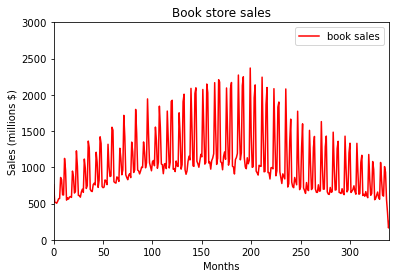

In [15]:
# Plot dataset
x = range(len(sales))
plt.plot(x, sales, 'r-', label='book sales')
plt.title('Book store sales')
plt.axis([0, 339, 0.0, 3000.0])
plt.xlabel('Months')
plt.ylabel('Sales (millions $)')
plt.legend()
plt.show()


For comparison purposes, create output corresponding to a naive model that predicts that the sales next month will be the same as the sales this month. Compare this to the correct data by plotting the values side by side.


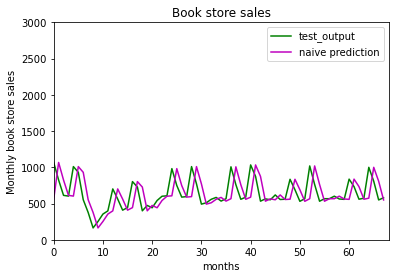

In [16]:
# Plot naive prediction
test_output = test_sales[MIN:]
naive_prediction = test_sales[MIN-1:-1]
x = range(len(test_output))
plt.plot(x, test_output, 'g-', label='test_output')
plt.plot(x, naive_prediction, 'm-', label='naive prediction')
plt.title('Book store sales')
plt.axis([0, len(test_output), 0.0, 3000.0])
plt.xlabel('months')
plt.ylabel('Monthly book store sales')
plt.legend()
plt.show()


The next step is to standardize the data points by subtracting the mean and dividing by the standard deviation of the training examples.


In [17]:
# Standardize train and test data.
# Use only training seasons to compute mean and stddev.
mean = np.mean(train_sales)
stddev = np.std(train_sales)
train_sales_std = (train_sales - mean)/stddev
test_sales_std = (test_sales - mean)/stddev


In our previous examples, the datasets were already organized into individual examples. For example, we had an array of images serving as input values and an associated array of classes serving as expected output values. However, the data that we created in this example is raw historical data and not yet organized as a set of training and test examples (see the section in the book for an illustration of how we need it organized). This is the next step in our code example. The code snippet below allocates tensors for the training data and initializes all entries to 0. It then loops through the historical data and creates training examples, then does the same thing with the test data.

In [18]:
# Create training examples.
train_months = len(train_sales)
train_X = np.zeros((train_months-MIN, train_months-1, 1))
train_y = np.zeros((train_months-MIN, 1))
for i in range(0, train_months-MIN):
    train_X[i, -(i+MIN):, 0] = train_sales_std[0:i+MIN]
    train_y[i, 0] = train_sales_std[i+MIN]

# Create test examples.
test_months = len(test_sales)
test_X = np.zeros((test_months-MIN, test_months-1, 1))
test_y = np.zeros((test_months-MIN, 1))
for i in range(0, test_months-MIN):
    test_X[i, -(i+MIN):, 0] = test_sales_std[0:i+MIN]
    test_y[i, 0] = test_sales_std[i+MIN]


We are finally ready to define and train our network. This is shown in the code snippet below.

In [19]:
# Create RNN model
model = Sequential()
model.add(Input(shape=(None, 1), batch_size=BATCH_SIZE))
model.add(SimpleRNN(128, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer = 'adam',
              metrics =['mean_absolute_error'])
model.summary()
history = model.fit(train_X, train_y,
                    validation_data
                    = (test_X, test_y), epochs=EPOCHS,
                    batch_size=BATCH_SIZE, verbose=2,
                    shuffle=True)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (16, 128)              │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (16, 1)                │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,769 (65.50 KB)

 Trainable params: 16,769 (65.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
20/20 - 3s - 160ms/step - loss: 0.6958 - mean_absolute_error: 0.6368 - val_loss: 0.2340 - val_mean_absolute_error: 0.4409
Epoch 2/100
20/20 - 1s - 62ms/step - loss: 0.3777 - mean_absolute_error: 0.4607 - val_loss: 0.1689 - val_mean_absolute_error: 0.3283
Epoch 3/100
20/20 - 2s - 92ms/step - loss: 0.1466 - mean_absolute_error: 0.2958 - val_loss: 0.1261 - val_mean_absolute_error: 0.3088
Epoch 4/100
20/20 - 2s - 90ms/step - loss: 0.0696 - mean_absolute_error: 0.1993 - val_loss: 0.1074 - val_mean_absolute_error: 0.2900
Epoch 5/100
20/20 - 2s - 78ms/step - loss: 0.0567 - mean_absolute_error: 0.1708 - val_loss: 0.0579 - val_mean_absolute_error: 0.1742
Epoch 6/100
20/20 - 1s - 71ms/step - loss: 0.0669 - mean_absolute_error: 0.1731 - val_loss: 0.0559 - val_mean_absolute_error: 0.1887
Epoch 7/100
20/20 - 1s - 69ms/step - loss: 0.0453 - mean_absolute_error: 0.1578 - val_loss: 0.0805 - val_mean_absolute_error: 0.2478
Epoch 8/100
20/20 - 1s - 74ms/step - loss: 0.0372 - mean_absolute_er

For comparison, create naive predictions based on standardized data.

In [20]:
# Create naive prediction based on standardized data.
test_output = test_sales_std[MIN:]
naive_prediction = test_sales_std[MIN-1:-1]
mean_squared_error = np.mean(np.square(naive_prediction
                                       - test_output))
mean_abs_error = np.mean(np.abs(naive_prediction
                                - test_output))
print('naive test mse: ', mean_squared_error)
print('naive test mean abs: ', mean_abs_error)


naive test mse:  0.26278257
naive test mean abs:  0.38861373


To shed some light on how this affects the end behavior, let us use our newly trained model to do some predictions and then plot these predictions next to the actual values. The code snippet below demonstrates how this can be done. We first call model.predict with the test input as argument. The second argument is the batch size, and we state the length of the input tensor as the batch size (i.e., we ask it to do a prediction for all the input examples in parallel). During training, the batch size will affect the result, but for prediction, it should not affect anything except for possibly runtime. We could just as well have used 16 or 32 or some other value. The model will return a 2D array with the output values. Because each output value is a single value, a 1D array works just as well, and that is the format we want in order to enable plotting the data, so we call np.reshape to change the dimensions of the array. The network works with standardized data, so the output will not represent demand directly. We must first destandardize the data by doing the reverse operation compared to the standardization. That is, we multiply by the standard deviation and add the mean. We then plot the data.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


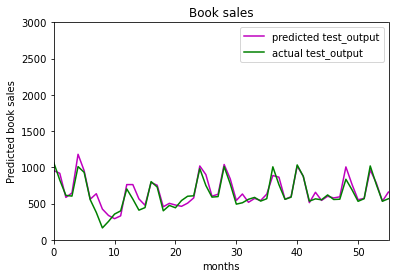

In [21]:
# Use trained model to predict the test data
predicted_test = model.predict(test_X, len(test_X))
predicted_test = np.reshape(predicted_test,
                            (len(predicted_test)))
predicted_test = predicted_test * stddev + mean

# Plot test prediction.
x = range(len(test_sales)-MIN)
plt.plot(x, predicted_test, 'm-',
         label='predicted test_output')
plt.plot(x, test_sales[-(len(test_sales)-MIN):],
         'g-', label='actual test_output')
plt.title('Book sales')
plt.axis([0, 55, 0.0, 3000.0])
plt.xlabel('months')
plt.ylabel('Predicted book sales')
plt.legend()
plt.show()
